In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [79]:
import datetime as dt
from datetime import datetime 

# Reflect Tables into SQLAlchemy ORM

In [80]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [81]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [82]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [83]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [84]:
# Save references to each table
Measurement= Base.classes.measurement
Station=Base.classes.station

In [85]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

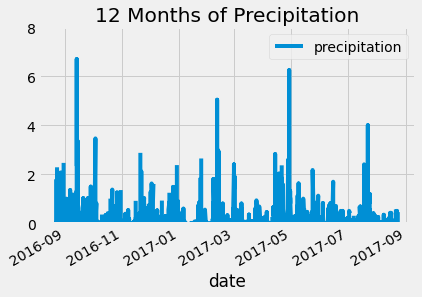

In [86]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date = last_date[0]

# Calculate the date 1 year ago from the last data point in the database
year_ago = dt.datetime.strptime(last_date, "%Y-%m-%d") - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
query= session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column, and change it's datatype
precipitation_df= pd.DataFrame(query, columns=['date', 'precipitation'])
precipitation_df['date'] = pd.to_datetime(precipitation_df['date'], format = '%Y-%m-%d')
precipitation_df.set_index('date', inplace=True)

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='date', ascending=True)
precipitation_df
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(title ="12 Months of Precipitation")
plt.legend(loc="upper right")
plt.ylim(0,8)
plt.savefig("Images/Precipitation.png")
plt.show()

In [87]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [88]:
# Design a query to show how many stations are available in this dataset?
session.query(Measurement.station).distinct().count()


9

In [89]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [90]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temp_stats = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station =='USC00519281').order_by(func.min(Measurement.tobs)).all()
#temp_stats
print(f"Low: {temp_stats[0][0]}, High: {temp_stats[0][1]}, Average: {temp_stats[0][2]}")


Low: 54.0, High: 85.0, Average: 71.66378066378067


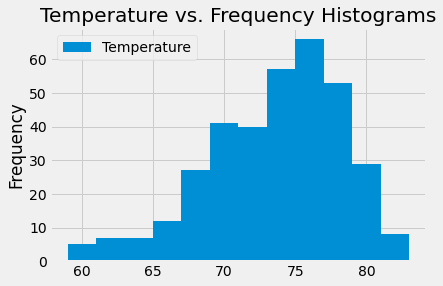

In [91]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
year_temp_stats=session.query(Measurement.tobs).filter(Measurement.date >= year_ago, Measurement.station =='USC00519281').order_by(Measurement.tobs).all()

year_temp_stats_df=pd.DataFrame(year_temp_stats, columns=["Temperature"])
year_temp_stats_df.plot.hist(bins=12, title="Temperature vs. Frequency Histograms")
plt.savefig("Images/TemperaturevFrequency.png")
plt.show()

## Bonus Challenge Assignment

In [92]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [93]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip (11/18/2013-11/25/2013) using the previous year's data for those same dates.
trip = calc_temps('2012-11-18', '2012-11-25')
trip



[(65.0, 71.96363636363637, 80.0)]

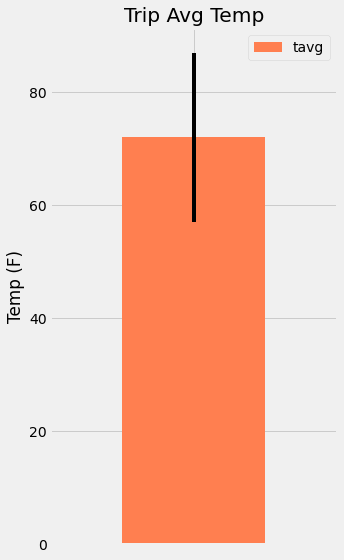

In [94]:
#Put Data into a DataFrame
trip_df=pd.DataFrame(trip, columns=['tmin', 'tavg', 'tmax'])

# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_df.plot.bar(y='tavg', yerr=(trip_df['tmax']-trip_df['tmin']), title='Trip Avg Temp', color='coral', figsize=(5,8))
plt.ylabel("Temp (F)")
plt.tick_params(axis='x', which='both', bottom=False, top=False,labelbottom=False)
plt.tight_layout()
plt.savefig("Images/Trip_Avg_Temp.png")
plt.show()

In [95]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def precipitation(start_date, end_date):
    #Docstring
    """Precipitation totals per weather station"""

    sel = [Measurement.station,
           Station.name,
           Station.latitude,
           Station.longitude,
           Station.elevation,
           Measurement.prcp]
    
    return session.query(*sel).filter(Measurement.station == Station.station).filter(Measurement.date >= start_date).filter(Measurement.date<=end_date).group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()

print(precipitation('2012-11-18', '2012-11-25'))

[('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.19), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.15), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.06), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.06), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.03), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.03), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, None), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, None)]


In [96]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [100]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`  
# Set the start and end date of the trip
start_date = dt.datetime.strptime('2013-11-18', '%Y-%m-%d')
end_date = dt.datetime.strptime('2013-11-25', '%Y-%m-%d')

# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date
normals=[]
trip_dates=[]

i_date= start_date
while i_date <=end_date:
    trip_dates.append(i_date)
    strip_start=i_date.strftime('%m-%d')
    i_date += dt.timedelta(1)
    normals.append(*daily_normals(strip_start))
    
normals

[(66.0, 73.55319148936171, 81.0),
 (64.0, 73.08333333333333, 81.0),
 (67.0, 73.03921568627452, 80.0),
 (66.0, 73.34, 81.0),
 (65.0, 71.98, 80.0),
 (64.0, 72.2, 80.0),
 (66.0, 72.56521739130434, 77.0),
 (63.0, 72.43181818181819, 78.0)]

In [101]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns=["Tmin", "Tavg", "Tmax"])
normals_df['Date']=pd.to_datetime(trip_dates)
normals_df.set_index('Date', inplace=True)
normals_df

,Tmin,Tavg,Tmax
Date,,,
2013-11-18,66.0,73.553191,81.0
2013-11-19,64.0,73.083333,81.0
2013-11-20,67.0,73.039216,80.0
2013-11-21,66.0,73.340000,81.0
2013-11-22,65.0,71.980000,80.0
2013-11-23,64.0,72.200000,80.0
2013-11-24,66.0,72.565217,77.0
2013-11-25,63.0,72.431818,78.0


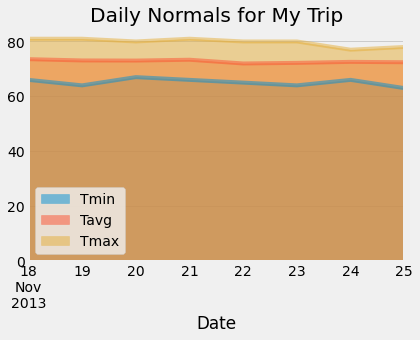

In [104]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot.area(stacked=False, title='Daily Normals for My Trip')
plt.xlabel("Date")
plt.ylim=(0,83)
plt.savefig('Images/daily_normals.png')
plt.show()